Shape of RGB images dataset: (871, 64, 64, 3)


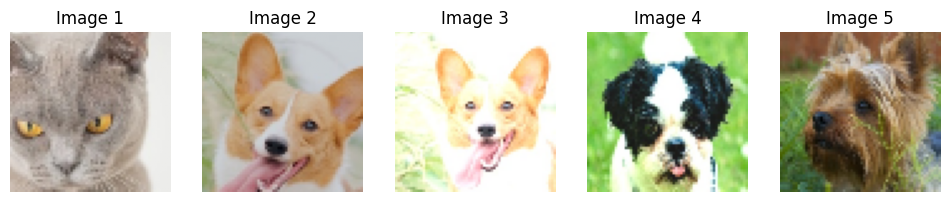

Shape of x_train: (696, 64, 64, 3)
Shape of x_test: (175, 64, 64, 3)
Epoch 1/50
3/3 [==============================] - 5s 147ms/step - loss: 0.0787 - val_loss: 0.0769
Epoch 2/50
3/3 [==============================] - 0s 51ms/step - loss: 0.0769 - val_loss: 0.0760
Epoch 3/50
3/3 [==============================] - 0s 51ms/step - loss: 0.0754 - val_loss: 0.0738
Epoch 4/50
3/3 [==============================] - 0s 44ms/step - loss: 0.0724 - val_loss: 0.0706
Epoch 5/50
3/3 [==============================] - 0s 43ms/step - loss: 0.0693 - val_loss: 0.0677
Epoch 6/50
3/3 [==============================] - 0s 37ms/step - loss: 0.0663 - val_loss: 0.0653
Epoch 7/50
3/3 [==============================] - 0s 38ms/step - loss: 0.0634 - val_loss: 0.0617
Epoch 8/50
3/3 [==============================] - 0s 36ms/step - loss: 0.0599 - val_loss: 0.0586
Epoch 9/50
3/3 [==============================] - 0s 37ms/step - loss: 0.0564 - val_loss: 0.0560
Epoch 10/50
3/3 [==============================] - 0s 39m

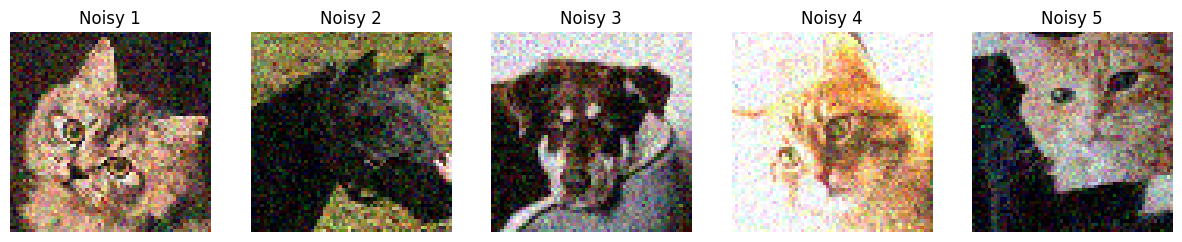

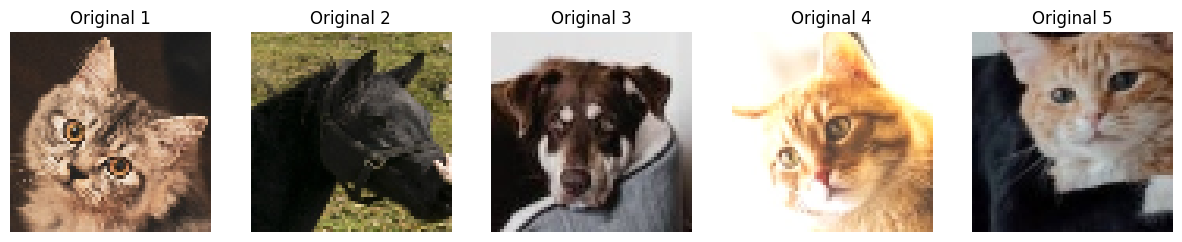

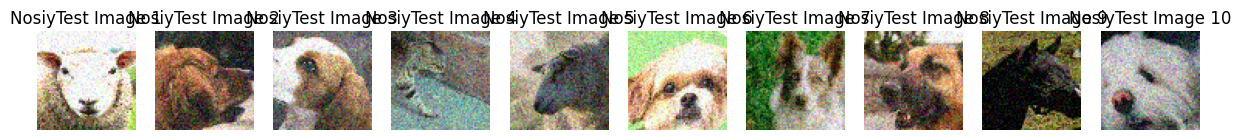

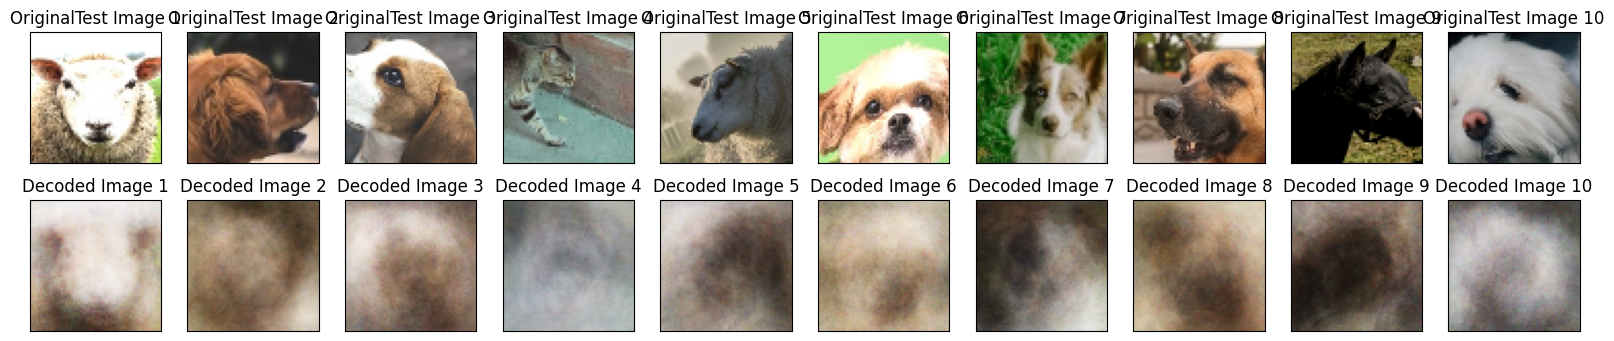

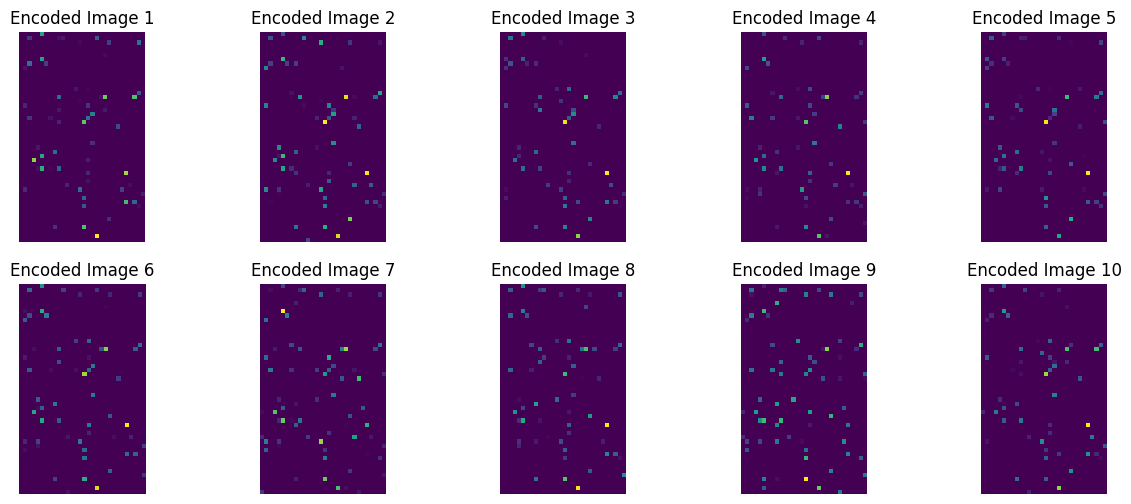

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 13 01:07:03 2023

@author: Abdelrahman


Case 1
"""

import cv2
import os
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import Input, Dense, GaussianNoise, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt



images_directory = "/kaggle/input/animals"


# Function to read and preprocess RGB images
def read_and_resize_rgb_images(directory):
    image_data = []

    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            file_path = os.path.join(directory, filename)
            img = cv2.imread(file_path)
            
            # Convert BGR to RGB 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Resize the image 
            img = cv2.resize(img, (64, 64))
            
            # Normalize pixel values to be between 0 and 1
            img = img / 255.0
            
            image_data.append(img)

    return np.array(image_data)

# Read, resize, and preprocess RGB images from the directory
rgb_images = read_and_resize_rgb_images(images_directory)

# Display the shape of the dataset
print("Shape of RGB images dataset:", rgb_images.shape)

# Display the first 5 images from the dataset
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(rgb_images[i])
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.show()


encoding_dim = 1500             # This is the size of our encoded representations
input_shape = (64, 64, 3)       # This is our input shape

input_img = keras.Input(shape=input_shape)
flat_input = layers.Flatten()(input_img)
encoded = layers.Dense(encoding_dim, activation='relu')(flat_input)
decoded = layers.Dense(np.prod(input_shape), activation='sigmoid')(encoded)
# Reshape the decoded output to match the original input shape
reshaped_decoded = layers.Reshape(input_shape)(decoded)
autoencoder = keras.Model(input_img, reshaped_decoded)

#Split Encoder and Decoder 
encoder = keras.Model(input_img, encoded)

encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-2]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))


#Compile the AutoEncoder Model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
x_train, x_test = train_test_split(
    rgb_images,
    test_size=0.2,  
    random_state=40  
)

# Display the shapes of the resulting sets
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)


noise_mu = 0  
noise_sigma = 0.1  

# Noise for Train and Test images
noisy_images = x_train + np.random.normal(loc=noise_mu, scale=noise_sigma, size=x_train.shape)
noisy_test_images = x_test + np.random.normal(loc=noise_mu, scale=noise_sigma, size=x_test.shape)

# Train the model
history = autoencoder.fit(
    noisy_images,
    x_train,
    epochs=50,
    batch_size=256,
    validation_data=(noisy_test_images, x_test)
)


encoded_imgs = encoder.predict(noisy_test_images)
decoded_imgs = decoder.predict(encoded_imgs)


n = 5  # Number of samples to visualize

# Noisy images samples
plt.figure(figsize=(15, 3))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(noisy_images[i])
    plt.title(f"Noisy {i + 1}")
    plt.axis('off')
plt.show()


# Original images for the noisy images samples
plt.figure(figsize=(15, 3))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_train[i])
    plt.title(f"Original {i + 1}")
    plt.axis('off')

plt.show()

n = 10

# Noisy Test Images
plt.figure(figsize=(15, 3))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(noisy_test_images[i])
    plt.title(f"NosiyTest Image {i + 1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.axis('off')

plt.show()


plt.figure(figsize=(20, 4))

for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(64, 64, 3))
    plt.title(f"OriginalTest Image {i + 1}")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64, 3))
    plt.gray()
    plt.title(f"Decoded Image {i + 1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


# Encoded Test Images
plt.figure(figsize=(15, 6))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(encoded_imgs[i].reshape(50,30) , cmap = 'viridis' ) 
    plt.title(f"Encoded Image {i + 1}")
    plt.axis('off')

plt.show()

Shape of RGB images dataset: (871, 64, 64, 3)


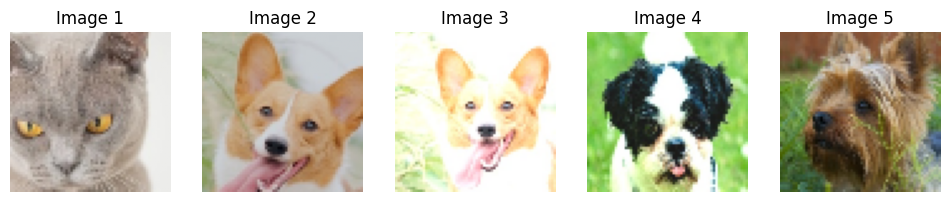

Shape of x_train: (696, 64, 64, 3)
Shape of x_test: (175, 64, 64, 3)
Epoch 1/100
3/3 [==============================] - 1s 115ms/step - loss: 0.0785 - val_loss: 0.0769
Epoch 2/100
3/3 [==============================] - 0s 47ms/step - loss: 0.0767 - val_loss: 0.0757
Epoch 3/100
3/3 [==============================] - 0s 46ms/step - loss: 0.0748 - val_loss: 0.0729
Epoch 4/100
3/3 [==============================] - 0s 41ms/step - loss: 0.0716 - val_loss: 0.0699
Epoch 5/100
3/3 [==============================] - 0s 41ms/step - loss: 0.0685 - val_loss: 0.0670
Epoch 6/100
3/3 [==============================] - 0s 39ms/step - loss: 0.0656 - val_loss: 0.0640
Epoch 7/100
3/3 [==============================] - 0s 38ms/step - loss: 0.0625 - val_loss: 0.0613
Epoch 8/100
3/3 [==============================] - 0s 36ms/step - loss: 0.0594 - val_loss: 0.0579
Epoch 9/100
3/3 [==============================] - 0s 38ms/step - loss: 0.0567 - val_loss: 0.0553
Epoch 10/100
3/3 [==============================

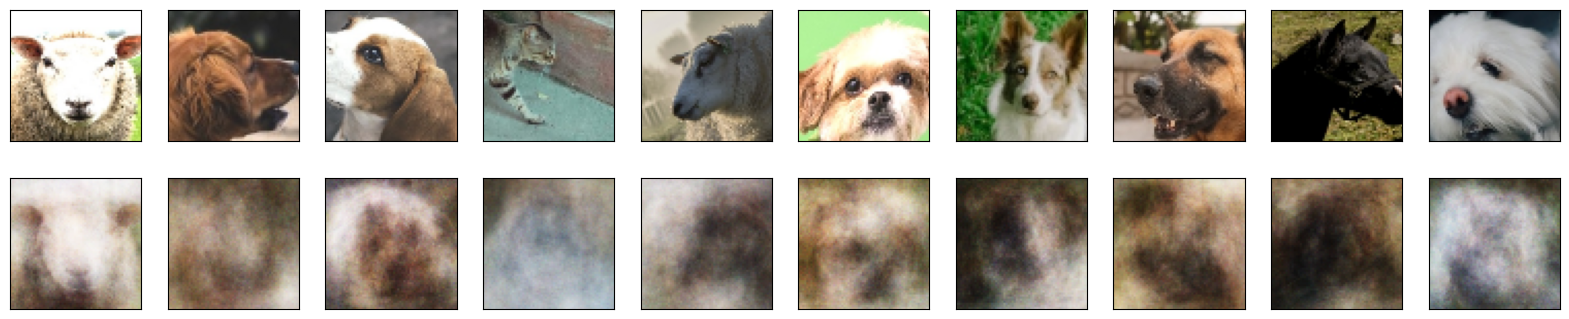

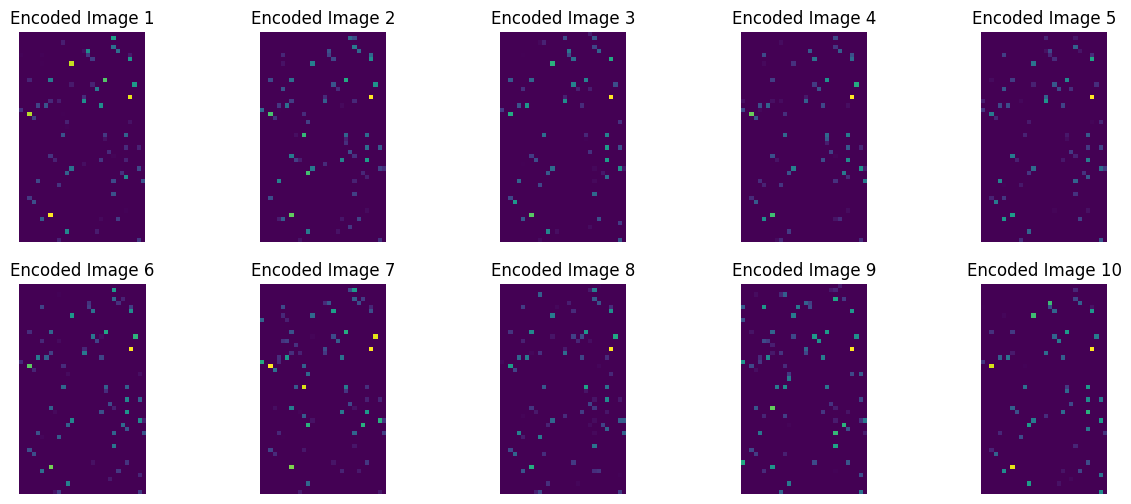

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 13 01:07:03 2023

@author: Abdelrahman


Case 2
"""

import cv2
import os
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import Input, Dense, GaussianNoise, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt



images_directory = "/kaggle/input/animals"


# Function to read and preprocess RGB images
def read_and_resize_rgb_images(directory):
    image_data = []

    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            file_path = os.path.join(directory, filename)
            img = cv2.imread(file_path)
            
            # Convert BGR to RGB 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Resize the image to the target shape
            img = cv2.resize(img, (64, 64))
            
            # Normalize pixel values to be between 0 and 1
            img = img / 255.0
            
            image_data.append(img)

    return np.array(image_data)

# Read, resize, and preprocess RGB images from the directory
rgb_images = read_and_resize_rgb_images(images_directory)

# Display the shape of the dataset
print("Shape of RGB images dataset:", rgb_images.shape)

# Display the first 5 images from the dataset
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(rgb_images[i])
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.show()


encoding_dim = 1500         # This is the size of our encoded representations (neurons)
input_shape = (64, 64, 3)    # Input shape

input_img = keras.Input(shape=input_shape)
flat_input = layers.Flatten()(input_img)
encoded = layers.Dense(encoding_dim, activation='relu')(flat_input)
decoded = layers.Dense(np.prod(input_shape), activation='sigmoid')(encoded)
# Reshape the decoded output to match the original input shape
reshaped_decoded = layers.Reshape(input_shape)(decoded)
autoencoder = keras.Model(input_img, reshaped_decoded)

#Split Encoder and Decoder
encoder = keras.Model(input_img, encoded)

encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-2]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))


#Compile the AutoEncoder Model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
x_train, x_test = train_test_split(
    rgb_images,
    test_size=0.2, 
    random_state=40  
)

# Display the shapes of the resulting sets
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)


noise_mu = 0  
noise_sigma = 0.1  


# Train the model
autoencoder.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=256,
    validation_data=(x_test, x_test)
)


encoded_imgs = encoder.predict(x_test)
# Adding noise to the Encoded_Imgs
noisy_code = encoded_imgs + np.random.normal(loc=noise_mu, scale=noise_sigma, size=encoded_imgs.shape)
decoded_imgs = decoder.predict(noisy_code)



n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Decoded images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64, 3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


# Encoded Test Images
plt.figure(figsize=(15, 6))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(encoded_imgs[i].reshape(50,30) , cmap = 'viridis' ) 
    plt.title(f"Encoded Image {i + 1}")
    plt.axis('off')

plt.show()



0.1581631810829135
(696, 12288)


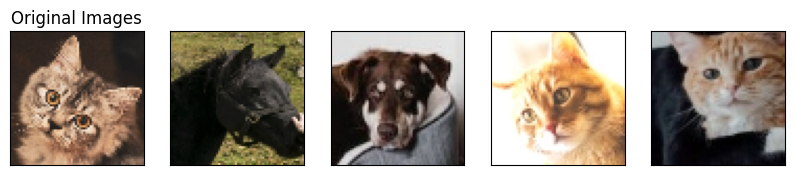

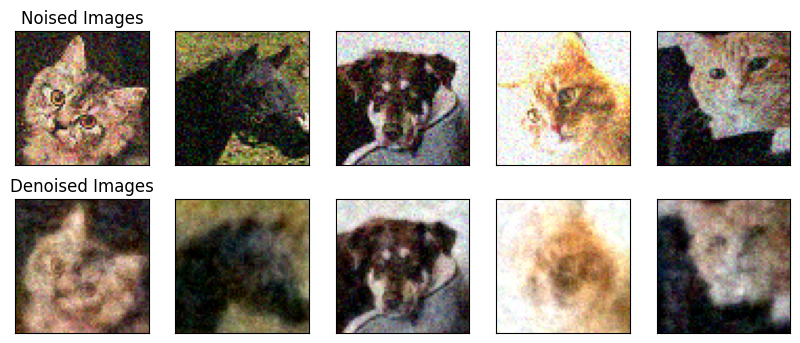

In [5]:
# Bonus
# PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# First we need to reshape the images to 2D.
rgb_images = rgb_images.reshape(871,12288)

# Normalize 
scaler = MinMaxScaler()
rgb_images_normalized = scaler.fit_transform(rgb_images)

# Add Gaussian noise to the normalized images
noise_mu = 0
noise_sigma = 0.1

# Split the data into training and testing sets
x_train, x_test = train_test_split(
    rgb_images_normalized,
    test_size=0.2, 
    random_state=40  
)

x_train_noisy = x_train + np.random.normal(loc=noise_mu, scale=noise_sigma, size=x_train.shape)


n_components = 150  # Adjust as needed

# PCA model
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_noisy)
loss =  1 - np.sum(pca.explained_variance_ratio_)
print(loss)

# Reconstruct the denoised images
x_train_denoised = pca.inverse_transform(x_train_pca)

print(x_train_denoised.shape)

# Reshape denoised images back to original shape
x_train_denoised = x_train_denoised.reshape((696, 64, 64, 3))


n = 5  # Number of images to display


plt.figure(figsize=(10, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        plt.title('Original Images')

plt.show()


plt.figure(figsize=(10, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train_noisy[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        plt.title('Noised Images')

    # Denoised images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_denoised[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        plt.title('Denoised Images')

plt.show()

In [52]:
# Subjective Measure

from skimage.metrics import structural_similarity as compare_ssim


# PCA SSIM
original_image1 = x_train[0].reshape(64,64,3)          # Replace with your original image
denoised_image1 = x_train_denoised[0].reshape(64,64,3)    # Replace with your denoised image

# Convert images to 8-bit unsigned integers
original_image1 = (original_image1 * 255).astype(np.uint8)
denoised_image1 = (denoised_image1 * 255).astype(np.uint8)

ssim_values1 = []
for channel in range(3):  # Iterate over channels
    ssim_channel1, _ = compare_ssim(original_image1[:, :, channel], denoised_image1[:, :, channel], full=True, win_size=7)
    ssim_values1.append(ssim_channel1)

# Average SSIM values across channels
average_ssim1 = np.mean(ssim_values1)

print("Average SSIM of PCA:", average_ssim1)


# AutoEncoder SSIM
original_image2 = x_train[0].reshape(64,64,3)          # Replace with your original image
denoised_image2 = decoded_imgs[0].reshape(64,64,3)    # Replace with your denoised image

# Convert images to 8-bit unsigned integers
original_image2 = (original_image2 * 255).astype(np.uint8)
denoised_image2 = (denoised_image2 * 255).astype(np.uint8)

ssim_values2 = []
for channel in range(3):
    ssim_channel2, _ = compare_ssim(original_image2[:, :, channel], denoised_image2[:, :, channel], full=True, win_size=7)
    ssim_values2.append(ssim_channel2)

# Average SSIM values across channels
average_ssim2 = np.mean(ssim_values2)

print("Average SSIM of AutoEncoder:", average_ssim2)


# Objective Measure
# Compression ratio of PCA

original_size1 = np.prod(x_train.shape)
compressed_size1 = n_components * x_train.shape[1]

PCA_compress1 = compressed_size1 / original_size1

print("Compress Ratio of PCA : " , PCA_compress1)


# Compression ratio of AutoEncoder
original_size2 = np.prod(x_train.shape)
compressed_size2 = encoding_dim * x_train.shape[0]

AE_compress2 = compressed_size2 / original_size2

print("Compress Ratio of AutoEncoder : " , AE_compress2)

Average SSIM of PCA: 0.056120110667066826
Average SSIM of AutoEncoder: 0.05216567818360004
Compress Ratio of PCA :  0.21551724137931033
Compress Ratio of AutoEncoder :  0.1220703125


In [44]:
from tensorflow.keras import layers

input_shape = (64, 64, 3)
input_layer = Input(shape=input_shape)

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_layer)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Model 
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.summary()

x_train_noisy = x_train + np.random.normal(loc=noise_mu, scale=noise_sigma, size=x_train.shape)
x_test_noisy = x_test + np.random.normal(loc=noise_mu, scale=noise_sigma, size=x_test.shape)


x_train_noise_reshaped = x_train_noisy.reshape((-1, 64, 64, 3))
x_train_reshaped = x_train.reshape((-1, 64, 64, 3))
x_test_noise_reshaped = x_test_noisy.reshape((-1,64,64,3))
x_test_reshaped = x_test.reshape((-1, 64, 64, 3))



# Fit the autoencoder model
autoencoder.fit(
    x_train_noise_reshaped,
    x_train_reshaped,
    epochs=50,
    batch_size=256,
    validation_data=(x_test_noise_reshaped, x_test_reshaped)
)

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_69 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_70 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_transpose_50 (Conv2  (None, 32, 32, 32)        924

6/6 [==============================] - 0s 5ms/step


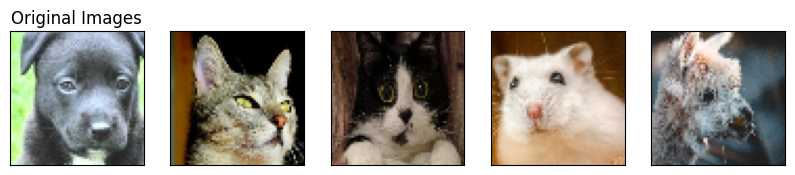

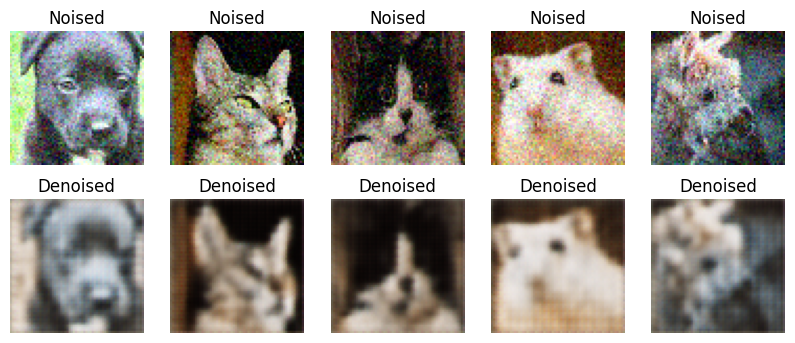

In [45]:
# Generate denoised images
denoised_images = autoencoder.predict(x_test_noise_reshaped)

n = 5  

plt.figure(figsize=(10, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_reshaped[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        plt.title('Original Images')

plt.show()

plt.figure(figsize=(10, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noise_reshaped[i])
    plt.title("Noised")
    plt.axis("off")

    # Display denoised images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(denoised_images[i])
    plt.title("Denoised")
    plt.axis("off")

plt.show()